In [20]:
import pandas as pd
import numpy as np
from catboost import CatBoostRanker, Pool
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt

# Process data

## Process members

In [2]:
members_df = pd.read_csv("members.csv", dtype={
        "msno": "category",
        "city": "category",
        "gender": "category",
        "registered_via": "category",
    })

def age_categories(row):
    if row == 0:
        row = 'UNK'
    else:
        row = row // 10
    return row

members_df.bd = members_df.bd.apply(age_categories).astype('category')
members_df.gender = members_df.gender.cat.add_categories('UNK').fillna('UNK')
members_df.registration_init_time = (members_df.registration_init_time // 100).astype('category')
members_df.expiration_date = (members_df.expiration_date // 100).astype('category')

members_df

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,UNK,UNK,7,201108,201709
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,UNK,UNK,7,201506,201706
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,UNK,UNK,4,201604,201707
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,UNK,UNK,9,201509,201509
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,UNK,UNK,4,201701,201706
...,...,...,...,...,...,...,...
34398,Wwd/cudKVuLJ3txRVxlg2Zaeliu+LRUfiBmfrnxhRCY=,1,UNK,UNK,7,201311,201709
34399,g3JGnJX6Hg50lFbrNWfsHwCUmApIkiv2M8sXOaeXoIQ=,4,1,male,3,201410,201705
34400,IMaPMJuyN+ip9Vqi+z2XuXbFAP2kbHr+EvvCNkFfj+o=,1,UNK,UNK,7,201308,201709
34401,WAnCAJjUty9Stv8yKtV7ZC7PN+ilOy5FX3aIJgGPANM=,1,UNK,UNK,7,201510,201709


## Process songs

In [3]:
songs_df = pd.read_csv("songs.csv", dtype={
        "song_id": "category",
        "genre_ids": "category",
        "artist_name": "category",
        "composer": "category",
        "lyricist": "category",
        "language": "category"
    })

song_extra_info_df = pd.read_csv("song_extra_info.csv", dtype={
        "song_id": "category",
        "name": "category",
        "isrc": "string"
    }).drop(columns=['name'])
    
songs_df = pd.merge(songs_df, song_extra_info_df, 'left')

In [4]:
for column in ['genre_ids', 'artist_name', 'composer', 'lyricist', 'language']:
    songs_df[column] = songs_df[column].cat.add_categories('UNK').fillna('UNK')
    
songs_df.isrc = songs_df.isrc.fillna('UNK')

In [5]:
def country(row):
    if row == 'UNK':
        return row
    else:
        return row[:2]

def year(row):
    if row == 'UNK':
        return row
    else:
        return row[5:7]

songs_df['country'] = songs_df.isrc.apply(country).astype('category')
songs_df['year'] = songs_df.isrc.apply(year).astype('category')
songs_df = songs_df.drop(columns=['isrc'])

In [6]:
songs_df


,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,country,year
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,TW,14
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,UNK,UNK
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,UNK,UNK,31.0,UNK,UNK
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0,TW,02
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0,UNK,UNK
...,...,...,...,...,...,...,...,...,...
2296315,lg6rn7eV/ZNg0+P+x77kHUL7GDMfoL4eMtXxncseLNA=,20192,958,Catherine Collard,Robert Schumann (1810-1856),UNK,-1.0,FR,78
2296316,nXi1lrSJe+gLoTTNky7If0mNPrIyCQCLwagwR6XopGU=,273391,465,紀文惠 (Justine Chi),UNK,UNK,3.0,TW,11
2296317,9KxSvIjbJyJzfEVWnkMbgR6dyn6d54ot0N5FKyKqii8=,445172,1609,Various Artists,UNK,UNK,52.0,DE,15
2296318,UO8Y2MR2sjOn2q/Tp8/lzZTGKmLEvwZ20oWanG4XnYc=,172669,465,Peter Paul & Mary,UNK,UNK,52.0,US,99


## Process train

In [7]:
train_df = pd.read_csv("train.csv", dtype={
        "msno": "category",
        "song_id": "category",
        "source_system_tab": "category",
        "source_screen_name": "category",
        "source_type": "category"
    })

for column in ['source_system_tab', 'source_screen_name', 'source_type']:
    train_df[column] = train_df[column].cat.add_categories('UNK').fillna('UNK')
    
train_df = train_df.merge(members_df, on='msno', how='left').merge(songs_df, on='song_id', how='left').astype({"msno": "category", "song_id": "category"})
train_df = train_df[~train_df.isna().any(1)]
train_df = train_df.sort_values("msno")

# Training

In [8]:
data = train_df.drop(columns=["target"])
label = train_df.target.to_numpy()
group_id = train_df.msno.cat.codes.to_numpy()
cat_features = train_df.select_dtypes(["category"]).columns.to_numpy()

In [19]:
results = []

for train_ids, val_ids in GroupKFold(n_splits=5).split(data, label, group_id):
    model = CatBoostRanker(
        loss_function='YetiRank',
        custom_metric='QueryAUC:type=Ranking',
        iterations=20
    )
    train_pool = Pool(data=data.iloc[train_ids], label=label[train_ids], group_id=group_id[train_ids], cat_features=cat_features, has_header=True)
    val_pool = Pool(data=data.iloc[val_ids], label=label[val_ids], group_id=group_id[val_ids], cat_features=cat_features, has_header=True)
    model.fit(train_pool, eval_set=val_pool)
    results.append(model.get_evals_result())

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Groupwise loss function. OneHotMaxSize set to 10
0:	test: 0.6182043	best: 0.6182043 (0)	total: 27.7s	remaining: 8m 46s
1:	test: 0.6182043	best: 0.6182043 (0)	total: 55.9s	remaining: 8m 23s
2:	test: 0.6181330	best: 0.6182043 (0)	total: 1m 26s	remaining: 8m 9s
3:	test: 0.6201020	best: 0.6201020 (3)	total: 1m 56s	remaining: 7m 46s
4:	test: 0.6201678	best: 0.6201678 (4)	total: 2m 27s	remaining: 7m 21s
5:	test: 0.6393430	best: 0.6393430 (5)	total: 2m 59s	remaining: 6m 57s
6:	test: 0.6393881	best: 0.6393881 (6)	total: 3m 41s	remaining: 6m 51s
7:	test: 0.6498107	best: 0.6498107 (7)	total: 4m 10s	remaining: 6m 16s
8:	test: 0.6554592	best: 0.6554592 (8)	total: 4m 38s	remaining: 5m 40s
9:	test: 0.7266022	best: 0.7266022 (9)	total: 5m 9s	remaining: 5m 9s
10:	test: 0.7281549	best: 0.7281549 (10)	total: 5m 38s	remaining: 4m 36s
11:	test: 0.7289941	best: 0.7289941 (11)	total: 6m 4s	remaining: 4m 3s
12:	test: 0.7289220	best: 0.7289941 (11)	total: 6m 30s	remaining: 3m 30s
13:	test: 0.7290280	best: 0.7

QueryAUC results:

Max QueryAUC = 0.5470369496277221


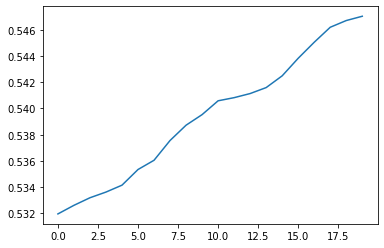

In [21]:
metrics = np.array([result['validation']['QueryAUC:type=Ranking'] for result in results]).mean(axis=0)
print('Max QueryAUC =', metrics.max())
plt.plot(range(len(metrics)), metrics)
plt.show()